In [1]:
import numpy as np
import pandas as pd
from numba import njit
from statsmodels.tsa.stattools import adfuller
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import shapiro
from joblib import Parallel, delayed

In [2]:
@njit
def calculate_weights_numba(d, thresh):
    w = [1.0]
    k = 1
    while True:
        w_ = -w[-1] * (d - k + 1) / k
        if abs(w_) < thresh:
            break
        w.append(w_)
        k += 1
    return np.array(w[::-1])

@njit
def frac_diff_numba(series_values, w, width):
    n = len(series_values)
    diff_series = np.empty(n)
    diff_series[:] = np.nan
    for i in range(width, n):
        diff_value = 0.0
        for j in range(width):
            diff_value += w[j] * series_values[i - width + j]
        diff_series[i] = diff_value
    return diff_series

def frac_diff_optimized(series, d, thresh=1e-5):
    """
    Aplica diferenciação fracionária à série temporal utilizando Numba para otimização.

    Parâmetros:
    - series: pd.Series, a série temporal a ser diferenciada.
    - d: float, ordem de diferenciação fracionária (0 < d < 1).
    - thresh: float, limiar para os coeficientes binomiais.

    Retorna:
    - pd.Series, série diferenciada fracionariamente.
    """
    # Calcular os coeficientes binomiais
    w = calculate_weights_numba(d, thresh)
    width = len(w)

    # Converter a série para um array numpy
    series_values = series.values
    n = len(series_values)

    # Aplicar a diferenciação fracionária utilizando Numba
    diff_series = frac_diff_numba(series_values, w, width)

    return pd.Series(diff_series, index=series.index)

def adf_test(series, title='ADF Test'):
    """
    Realiza o teste de Dickey-Fuller aumentado e imprime os resultados.

    Parâmetros:
    - series: pd.Series, a série temporal a ser testada.
    - title: str, título para identificar o teste.

    Retorna:
    - None
    """
    print(f'\n==== {title} ====')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['Estatística ADF', 'p-valor', 'Número de Lags Usados', 'Número de Observações Usadas']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Valor Crítico ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("Evidência forte contra a hipótese nula (presença de raiz unitária), rejeitamos a hipótese nula.")
    else:
        print("Evidência fraca contra a hipótese nula, não rejeitamos a hipótese nula.")

def create_lag_matrix(series, n_lags):
    """
    Cria uma matriz de lags para a série temporal.

    Parâmetros:
    - series: pd.Series, a série temporal.
    - n_lags: int, número de lags a serem criados.

    Retorna:
    - X: np.ndarray, matriz de lags.
    - y: np.ndarray, variável alvo ajustada.
    """
    # Criar um DataFrame com as lags
    df_lags = pd.concat([series.shift(i) for i in range(1, n_lags + 1)], axis=1)
    df_lags.columns = [f'lag_{i}' for i in range(1, n_lags + 1)]

    # Remover linhas com NaN causados pelo shift
    df_lags = df_lags.dropna()

    # Variável alvo
    y = series.loc[df_lags.index].values

    # Converter para array NumPy
    X = df_lags.values

    return X, y

def monteCarlo(serie_predita, constant, params, order):
    out = len(serie_predita)
    Y = np.zeros(out)
    Y[:(order)] = serie_predita.iloc[:(order)]

    for i in range(order, out):
        # Extract the relevant data and transpose if needed
        data = serie_predita.iloc[i-order:i].values
        phi_transpose = np.transpose(params)

        Y[i] = data @ phi_transpose + constant

    Y = pd.DataFrame(Y)
    Y.index = serie_predita.index
    Y.rename(columns={0: 'fraqdiff_pred'}, inplace=True)
    return Y

def auto_reg(order, serie_predita):
    """
    Ajusta um modelo autoregressivo e retorna previsões alinhadas com a série original.

    Parameters:
    - order (int): Ordem do modelo autoregressivo.
    - serie_predita (pd.Series): Série temporal para ajustar o modelo.

    Returns:
    - Y_pred_aligned (pd.Series): Série de previsões alinhadas com a série original.
    - constant (float): Constante do modelo.
    - params (pd.Series): Parâmetros do modelo.
    """
    # Garantir que serie_predita é uma pandas Series
    if not isinstance(serie_predita, pd.Series):
        serie_predita = pd.Series(serie_predita)

    # Criar matriz de lags sem usar np.roll para evitar deslocamento circular
    X = pd.concat([serie_predita.shift(i+1) for i in range(order)], axis=1)
    X.columns = [f'lag_{i+1}' for i in range(order)]

    # Remover linhas com NaN devido aos lags
    X = X.dropna()
    y = serie_predita.loc[X.index]

    # Adicionar constante
    X = sm.add_constant(X)

    # Ajustar o modelo autoregressivo
    model = sm.OLS(y, X)
    result = model.fit()

    # Exibir o resumo do modelo
    print(result.summary())

    # Obter parâmetros
    constant = result.params['const']
    params = result.params.drop('const')

    # Prever os valores in-sample
    Y_pred = result.predict(X)

    # Garantir que Y_pred está alinhado com y
    Y_pred_aligned = Y_pred.copy()
    Y_pred_aligned.index = y.index

    return Y_pred_aligned, constant, params


In [3]:
# Função de diferenciação fracionária otimizada com Numba
@njit
def frac_diff_numba(series, w, width):
    diff_series = np.empty(len(series), dtype=np.float64)
    for i in range(len(series)):
        if i < width:
            diff_series[i] = 0.0  # Placeholder, será substituído por NaN no pandas
        else:
            value = 0.0
            for j in range(width):
                value += w[j] * series[i - j]
            diff_series[i] = value
    return diff_series

def frac_diff_optimized(series, d, max_lag=100):
    """
    Aplica diferenciação fracionária na série fornecida.

    Parameters:
    - series: pd.Series, a série temporal a ser diferenciada.
    - d: float, o parâmetro de diferenciação fracionária.
    - max_lag: int, o número máximo de lags para calcular os pesos.

    Returns:
    - pd.Series, a série diferenciada com NaNs removidos.
    """
    # Calcula os pesos da diferenciação fracionária
    w = [1.0]
    for k in range(1, max_lag):
        w_ = -w[-1] * (d - k + 1) / k
        w.append(w_)
        if abs(w[-1]) < 1e-5:
            break
    width = len(w)

    # Assegura que os valores são float64
    series_values = series.values.astype(np.float64)

    # Aplica a diferenciação fracionária com Numba
    diff_series = frac_diff_numba(series_values, np.array(w, dtype=np.float64), width)

    # Cria a série diferenciada com o índice original
    diff_series = pd.Series(diff_series, index=series.index)

    # Substitui os placeholders (0.0) por NaN nos primeiros 'width' registros
    diff_series.iloc[:width] = np.nan

    # Remove os NaNs resultantes
    diff_series = diff_series.dropna()

    return diff_series

# Função para realizar o teste ADF
def adf_test(series, title=''):
    result = adfuller(series, autolag='AIC')
    print(f'== {title} ==')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')
    print('')

# Função para criar matriz de lags
def create_lag_matrix(series, n_lags):
    """
    Cria uma matriz de lags para modelagem.

    Parameters:
    - series: pd.Series, a série temporal.
    - n_lags: int, o número de lags a serem criados.

    Returns:
    - X: np.ndarray, matriz de lags.
    - y: np.ndarray, variável alvo.
    """
    X = pd.concat([series.shift(i) for i in range(1, n_lags + 1)], axis=1)
    y = series
    X = X.dropna()
    y = y.loc[X.index]
    return X.values, y.values

# Função autoregressiva (retorna Y_pred como Series com índice alinhado)
def auto_reg(order, series):
    """
    Ajusta um modelo autoregressivo e retorna as previsões.

    Parameters:
    - order: int, a ordem do modelo autoregressivo.
    - series: pd.Series, a série temporal diferenciada.

    Returns:
    - Y_pred_series: pd.Series, as previsões do modelo.
    - constant: float, o termo constante do modelo.
    - params: pd.Series, os coeficientes do modelo.
    """
    from statsmodels.tsa.ar_model import AutoReg
    model = AutoReg(series, lags=order, old_names=False)
    model_fit = model.fit()
    Y_pred = model_fit.predict(start=order, end=len(series)-1)
    # Alinhar o índice de Y_pred com a série original
    Y_pred_series = pd.Series(Y_pred, index=series.index[order:], name='Y_pred')
    constant = model_fit.params[0]
    params = model_fit.params[1:]
    return Y_pred_series, constant, params

START: COMECAR AQUI

In [4]:
# Leitura da série
series = pd.read_parquet("../output/dollar-bars-[10000000]/dollar_bars.parquet/part.0.parquet")
print("Primeiras linhas do dataset original:")
print(series.head())

# Verifique se a coluna 'time' está no formato de string de data/hora e converta para datetime
series['time'] = pd.to_datetime(series['time'])  # Removido unit='ns'

# Definir 'time' como índice e ordenar
series = series.set_index('time').sort_index()

# Verifique as primeiras linhas para garantir que o índice está correto
print("\nPrimeiras linhas após definir 'time' como índice:")
print(series.head())

# Verifique se o índice está ordenado e sem duplicatas
if not series.index.is_monotonic_increasing:
    raise ValueError("O índice 'time' não está ordenado de forma crescente.")
if series.index.duplicated().any():
    raise ValueError("O índice 'time' contém valores duplicados.")

Primeiras linhas do dataset original:
            trade_count  price_open  price_high  price_low  price_close  \
bar_number                                                                
7119               8756     7390.00     7420.96    7359.00      7372.79   
7178               7240     6900.00     6983.94    6884.00      6937.33   
7209               9124     6982.70     7003.00    6952.02      6966.04   
7229               8704     7049.99     7120.00    7011.00      7037.75   
7242               7420     7083.42     7117.66    7081.02      7109.89   

                qty_sum  quoteQty_sum                    time  \
bar_number                                                      
7119        1355.914634  1.000972e+07 2018-08-03 01:04:21.488   
7178        1444.857169  1.000110e+07 2018-08-05 01:39:18.097   
7209        1433.470974  1.000027e+07 2018-08-06 09:57:48.193   
7229        1418.377902  1.000105e+07 2018-08-07 07:55:38.830   
7242        1411.392764  1.002079e+07 2018-08-

In [5]:
# Definir o valor de diferenciação fracionária
d = 0.3

# Aplicar a diferenciação fracionária na coluna 'price_close' e remover NaNs
print("\nAplicando diferenciação fracionária na série 'price_close'...")
series_frac_diff = frac_diff_optimized(series['price_close'], d).dropna()
print("Diferenciação fracionária concluída.")

# Resetar o índice da série diferenciada para alinhamento baseado em inteiros
series_frac_diff = series_frac_diff.reset_index(drop=True)

# Realizar o teste ADF na série diferenciada completa
adf_test(series_frac_diff, title=f'Preço de Fechamento (price_close) - Diferenciação Fracionária d={d}')

# Exibir as primeiras linhas da série diferenciada
print("\nPrimeiras linhas da série diferenciada:")
display(series_frac_diff.head())


Aplicando diferenciação fracionária na série 'price_close'...
Diferenciação fracionária concluída.
== Preço de Fechamento (price_close) - Diferenciação Fracionária d=0.3 ==
ADF Statistic: -2.4651938758328553
p-value: 0.12417429960391668
Critical Value 1%: -3.4311596768101715
Critical Value 5%: -2.8618978196173055
Critical Value 10%: -2.5669604626428453


Primeiras linhas da série diferenciada:


0    1207.010735
1    1480.235373
2    1325.698454
3    2036.778592
4    2607.702379
dtype: float64

In [6]:
# # Definir o tamanho da amostra (5% dos dados)
# sample_size = int(len(series_frac_diff) * 0.05)  # Aumentado para 5%
# series_frac_diff_sample = series_frac_diff.sample(n=sample_size, random_state=42).sort_index()

# # Realizar o teste ADF na amostra de 5%
# adf_test(series_frac_diff_sample, title=f'Preço de Fechamento (price_close) - Diferenciação Fracionária d={d} (5% Amostra)')

# # Exibir as primeiras linhas da amostra diferenciada
# print("\nPrimeiras linhas da amostra diferenciada (5%):")
# display(series_frac_diff_sample.head())

In [7]:
# Criar matriz de lags para LinearRegression (se necessário)
n_lags = 1
X, y = create_lag_matrix(series_frac_diff, n_lags)
print(f"\nMatriz de lags criada com forma: {X.shape}")
print(f"Variável alvo (y) criada com forma: {y.shape}")



Matriz de lags criada com forma: (8114, 1)
Variável alvo (y) criada com forma: (8114,)


In [8]:
# Aplicar PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("\nVariância explicada acumulada:", cumulative_variance)

# Determinar número de componentes
n_components_var = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Número ótimo de componentes (95% da variância explicada): {n_components_var}")

# Reduzir dimensionalidade
n_components = n_components_var
pca_reduced = PCA(n_components=n_components)
X_reduced = pca_reduced.fit_transform(X_scaled)
print(f"Forma da matriz após PCA: {X_reduced.shape}")

# Aplicação em modelagem com LinearRegression
model = LinearRegression()
scores = cross_val_score(model, X_reduced, y, cv=5, scoring='neg_mean_squared_error')
print(f"\nMSE médio (5-fold CV): {-np.mean(scores):.4f}")

# Plotar ACF e PACF para análise
desired_lags = 40
sample_size_plot = len(series_frac_diff)
max_allowed_lags = sample_size_plot // 2 - 1
adjusted_lags = min(desired_lags, max_allowed_lags)

# print(f"\nUsando lags={adjusted_lags} para a amostra de tamanho {sample_size_plot}")

# fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# # Série Completa
# plot_acf(series_frac_diff, ax=axes[0, 0], lags=desired_lags, zero=False)
# axes[0, 0].set_title(f'ACF - Série Completa (d={d})')

# plot_pacf(series_frac_diff, ax=axes[1, 0], lags=desired_lags, zero=False, method='ywm')
# axes[1, 0].set_title(f'PACF - Série Completa (d={d})')

# # Amostra de 5%
# plot_acf(series_frac_diff_sample, ax=axes[0, 1], lags=adjusted_lags, zero=False)
# axes[0, 1].set_title(f'ACF - 5% Amostra (d={d})')

# plot_pacf(series_frac_diff_sample, ax=axes[1, 1], lags=adjusted_lags, zero=False, method='ywm')
# axes[1, 1].set_title(f'PACF - 5% Amostra (d={d})')

# plt.tight_layout()
# plt.show()



Variância explicada acumulada: [1.]
Número ótimo de componentes (95% da variância explicada): 1
Forma da matriz após PCA: (8114, 1)

MSE médio (5-fold CV): 279357.2264


In [9]:
# Aplicar a função autoregressiva
order = n_lags  # Defina a ordem do modelo autoregressivo para igualar o número de lags

x_series = pd.DataFrame(X_reduced)[0]

Y_pred, constant, params = auto_reg(order, x_series)

/var/folders/fk/hqjyfhd57_5gtv7tsfr9jfgm0000gn/T/ipykernel_15865/973906362.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  constant = model_fit.params[0]



Primeiras linhas dos resíduos:


0    0.059949
1   -0.064417
2    0.188651
3    0.150089
4   -0.293012
dtype: float64

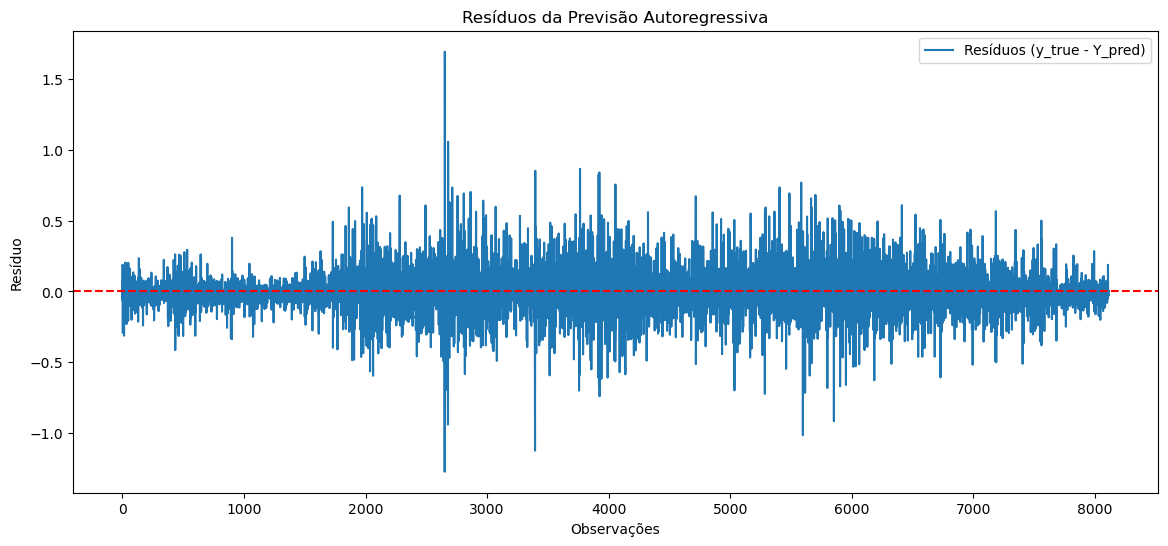


Estatísticas dos Resíduos:
count    8.113000e+03
mean     4.895765e-16
std      1.535911e-01
min     -1.273201e+00
25%     -6.826818e-02
50%     -5.855706e-03
75%      6.536145e-02
max      1.693507e+00
dtype: float64


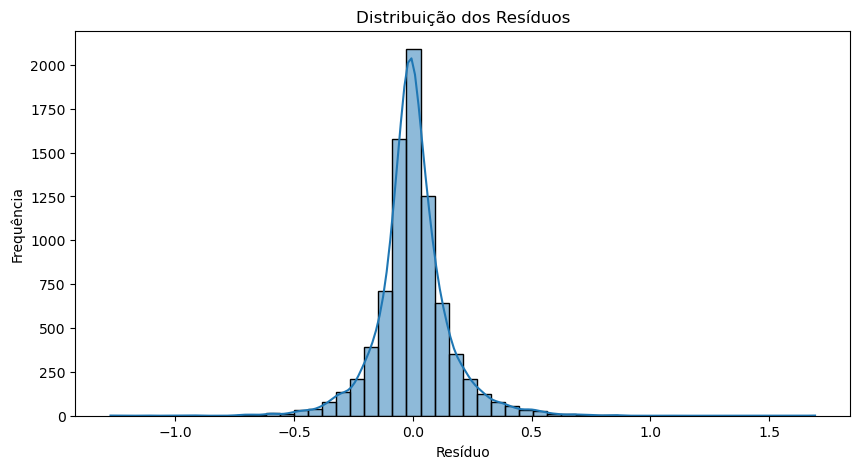


Estatística Shapiro-Wilk: 0.9230, p-valor: 0.0000
Os resíduos não seguem uma distribuição normal (rejeita H0).


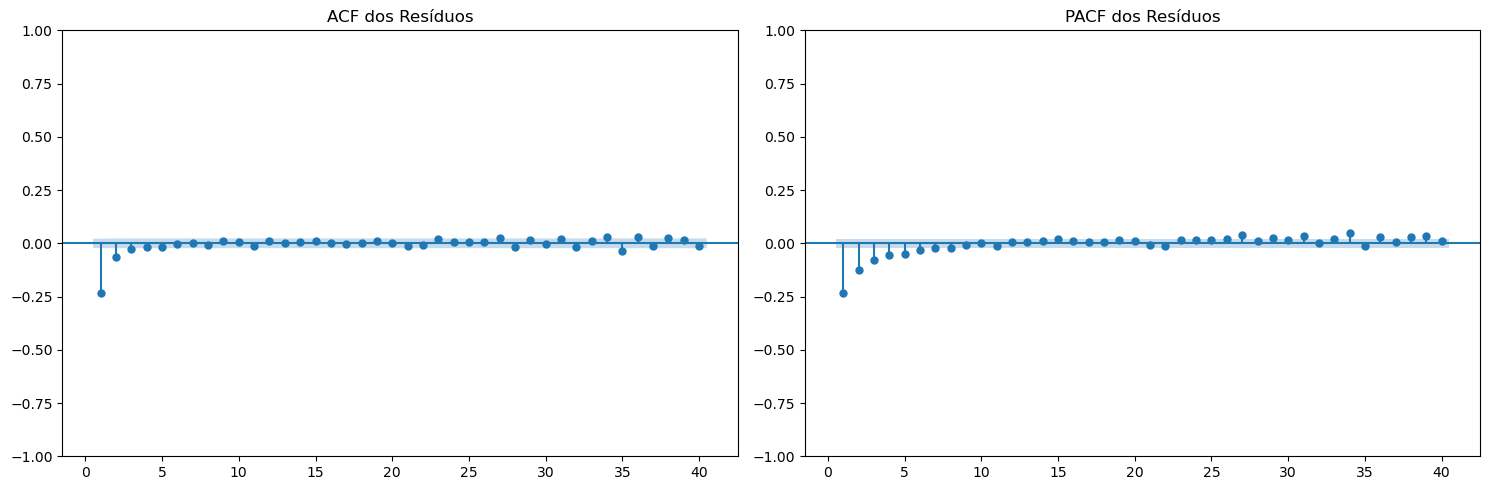

In [10]:
# # Visualizar a série prevista
# plt.figure(figsize=(14,6))
# plt.plot(series_frac_diff, label='Série Diferenciada Fracionária', alpha=0.5)
# plt.plot(Y_pred, label='Série Prevista', alpha=0.7)
# plt.legend()
# plt.title('Comparação entre Série Diferenciada e Série Prevista')
# plt.xlabel('Observações')
# plt.ylabel('Preço Diferenciado')
# plt.show()

# Análise de Resíduos
# Definir y_series como a série diferenciada a partir do índice 'order'
y_series = x_series.iloc[order:].reset_index(drop=True)

# Garantir que Y_pred é uma pandas Series com o mesmo comprimento que y_series
Y_pred = Y_pred.reset_index(drop=True)
Y_pred = Y_pred.iloc[:len(y_series)]

# Calcular os resíduos
residuals = y_series - Y_pred

# Exibir as primeiras linhas dos resíduos
print("\nPrimeiras linhas dos resíduos:")
display(residuals.head())

# Plotar os resíduos ao longo do tempo
plt.figure(figsize=(14,6))
plt.plot(residuals, label='Resíduos (y_true - Y_pred)')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.title('Resíduos da Previsão Autoregressiva')
plt.xlabel('Observações')
plt.ylabel('Resíduo')
plt.show()

# Estatísticas descritivas dos resíduos
print("\nEstatísticas dos Resíduos:")
print(residuals.describe())

# Plotar histograma dos resíduos
plt.figure(figsize=(10,5))
sns.histplot(residuals, kde=True, bins=50)
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')
plt.show()

# Teste de normalidade (Shapiro-Wilk)
# Shapiro-Wilk tem limite de amostra (normalmente até 5000 observações)
sample_size_shapiro = min(5000, len(residuals))
sample_residuals = residuals.sample(n=sample_size_shapiro, random_state=42)
stat, p_value = shapiro(sample_residuals)
print(f"\nEstatística Shapiro-Wilk: {stat:.4f}, p-valor: {p_value:.4f}")
if p_value > 0.05:
    print("Os resíduos parecem seguir uma distribuição normal (não rejeita H0).")
else:
    print("Os resíduos não seguem uma distribuição normal (rejeita H0).")

# Autocorrelação dos resíduos
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# ACF dos resíduos
plot_acf(residuals, ax=ax[0], lags=40, zero=False)
ax[0].set_title('ACF dos Resíduos')

# PACF dos resíduos
plot_pacf(residuals, ax=ax[1], lags=40, zero=False, method='ywm')
ax[1].set_title('PACF dos Resíduos')

plt.tight_layout()
plt.show()

In [11]:
def getVol(close, span0=200):
    # Calcula o índice do dia anterior para cada data no índice de 'close'
    df0 = close / close.shift() - 1

    # Aplica uma média móvel exponencial no desvio padrão dos retornos
    df0 = df0.ewm(span=span0).std()

    return df0


In [12]:
vol = getVol(series['price_close'], span0=200)
series['vol'] = vol
residuals.index = series.index[102:]
series['residuals'] = residuals
series.dropna(inplace=True)

# Cusum Simétrico

In [13]:
def getTEvents(gRaw, h, tau):
    tEvents, sPos, sNeg = [], 0, 0
    for i in gRaw.index:
        sPos, sNeg = max(0, sPos + gRaw.loc[i]), min(0, sNeg + gRaw.loc[i])
        t_short = -h.loc[i] * tau
        t_long = h.loc[i] * tau
        if sNeg < t_short:
            sNeg = 0
            tEvents.append([i,  abs(t_short), -1])
        elif sPos > t_long:
            sPos = 0
            tEvents.append([i, t_long, 1])
    return pd.DataFrame(tEvents)


In [14]:
series.dropna(inplace=True)
tau = 5
sTime = 6000

events = getTEvents(series['residuals'], series['vol'], tau)
events.columns = ['time', 'trgt', 'side']
events.set_index('time', inplace=True)
events['t1'] = events.index + pd.Timedelta(minutes=sTime)
events

,trgt,side,t1
time,,,
2018-03-07 21:48:39.376,0.454891,-1,2018-03-12 01:48:39.376
2018-03-15 05:32:57.304,0.434038,-1,2018-03-19 09:32:57.304
2018-03-28 10:59:37.862,0.390509,-1,2018-04-01 14:59:37.862
2018-03-30 08:20:11.643,0.380478,-1,2018-04-03 12:20:11.643
2018-05-02 08:21:12.719,0.319213,-1,2018-05-06 12:21:12.719
...,...,...,...
2022-08-04 17:28:13.315,0.042332,-1,2022-08-08 21:28:13.315
2022-08-05 02:47:04.046,0.044206,-1,2022-08-09 06:47:04.046
2022-08-05 03:28:46.519,0.044025,1,2022-08-09 07:28:46.519


In [15]:
def applyPtSlOnT1(close, events, ptSl, molecule):
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)

    if ptSl[0] > 0:
        pt = ptSl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events_.index, dtype='float64')

    if ptSl[1] > 0:
        sl = -ptSl[1] * events_['trgt']
    else:
        sl = pd.Series(index=events_.index, dtype='float64')

    out['sl'] = np.nan
    out['pt'] = np.nan
    out['retorno'] = np.nan
    out['max_drawdown_in_trade'] = np.nan  # Nova coluna para o drawdown interno

    filled_t1 = events_['t1'].fillna(close.index[-1])

    for loc, t1 in filled_t1.items():
        # Preço inicial da operação
        initial_price = close.asof(loc)
        
        # Extraímos o intervalo de preços da operação (inclui o ponto inicial e final)
        df0 = close.loc[loc:t1]
        
        side = events_.at[loc, 'side']
        if side == 1:
            # Operação comprada
            ret = df0 / initial_price - 1
        elif side == -1:
            # Operação vendida
            ret = initial_price / df0 - 1
        else:
            raise ValueError(f"Valor inválido para 'side' em {loc}: {side}")

        # Verificar barreiras
        sl_hit = ret[ret < sl.loc[loc]].index.min() if ptSl[1] > 0 else np.nan
        pt_hit = ret[ret > pt.loc[loc]].index.min() if ptSl[0] > 0 else np.nan

        # Determinar qual barreira foi atingida primeiro
        barrier_times = [(sl_hit, 'sl'), (pt_hit, 'pt'), (t1, 't1')]
        barrier_times = [(bt, name) for bt, name in barrier_times if pd.notna(bt)]
        if not barrier_times:
            barrier_time = t1
            barrier_name = 't1'
        else:
            barrier_time, barrier_name = sorted(barrier_times, key=lambda x: x[0])[0]

        out.at[loc, barrier_name] = barrier_time

        # Preço final no momento da barreira
        final_price = close.asof(barrier_time)
        if side == 1:
            final_return = (final_price / initial_price) - 1
        else:
            final_return = (initial_price / final_price) - 1

        out.at[loc, 'retorno'] = final_return

        # Cálculo do drawdown máximo dentro da operação:
        # Ajustamos a série de retornos para começar em 0 no início do trade
            # Cálculo do drawdown máximo dentro da operação
        if side == 1:
            running_max = df0.cummax()
            dd = (df0 - running_max) / running_max
        else:
            running_min = df0.cummin()
            dd = (running_min - df0) / running_min
        max_dd = dd.min()

        out.at[loc, 'max_drawdown_in_trade'] = max_dd

    return out


In [16]:
def get_label(row):
    if pd.notna(row['pt']) and (pd.isna(row['sl']) or row['pt'] < row['sl']):
        return 1  # Take Profit
    elif pd.notna(row['sl']) and (pd.isna(row['pt']) or row['sl'] < row['pt']):
        return -1  # Stop Loss
    else:
        return 0  # Apenas a barreira vertical foi atingida

In [17]:
# Aplicação do Método da Tríplice Barreira

# Definir os parâmetros para as barreiras
ptSl = [2.0, 1.0]  # Exemplo: take profit a 2 vezes o target, stop loss a 1 vez o target

close = series['price_close']
# Remover eventos cujo t1 ultrapassa o índice do 'close'
events['t1'] = events['t1'].where(events['t1'] <= close.index[-1], pd.NaT)

# Definir o molecule (conjunto de eventos a serem processados)
# Por exemplo, todos os eventos
molecules = events.index.tolist()

# Aplicar a função
triple_barrier_events = Parallel(n_jobs=1)(
            delayed(applyPtSlOnT1)(close, events.loc[[molecule]], ptSl, [molecule]) for molecule in molecules)
triple_barrier_events = pd.concat(triple_barrier_events)
triple_barrier_events['label'] = triple_barrier_events.apply(get_label, axis=1)

print("Eventos com barreiras aplicadas e rótulos:")
print(triple_barrier_events.head())


/var/folders/fk/hqjyfhd57_5gtv7tsfr9jfgm0000gn/T/ipykernel_15865/1844443359.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2019-07-02 04:40:15.420000' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  out.at[loc, barrier_name] = barrier_time
/var/folders/fk/hqjyfhd57_5gtv7tsfr9jfgm0000gn/T/ipykernel_15865/1844443359.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2019-10-26 06:48:00.250000' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  out.at[loc, barrier_name] = barrier_time
/var/folders/fk/hqjyfhd57_5gtv7tsfr9jfgm0000gn/T/ipykernel_15865/1844443359.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2020-03-12 10:59:46.658000' has dtype incomp

Eventos com barreiras aplicadas e rótulos:
                                             t1   sl   pt   retorno  \
time                                                                  
2018-03-07 21:48:39.376 2018-03-12 01:48:39.376  NaN  NaN  0.040317   
2018-03-15 05:32:57.304 2018-03-19 09:32:57.304  NaN  NaN -0.053725   
2018-03-28 10:59:37.862 2018-04-01 14:59:37.862  NaN  NaN  0.152524   
2018-03-30 08:20:11.643 2018-04-03 12:20:11.643  NaN  NaN  0.030874   
2018-05-02 08:21:12.719 2018-05-06 12:21:12.719  NaN  NaN -0.056696   

                         max_drawdown_in_trade  label  
time                                                   
2018-03-07 21:48:39.376              -0.120593      0  
2018-03-15 05:32:57.304              -0.067573      0  
2018-03-28 10:59:37.862              -0.075374      0  
2018-03-30 08:20:11.643               0.000000      0  
2018-05-02 08:21:12.719              -0.068646      0  


In [18]:
triple_barrier_events.to_excel('vetor-entrada.xlsx')

In [19]:
triple_barrier_events

,t1,sl,pt,retorno,max_drawdown_in_trade,label
time,,,,,,
2018-03-07 21:48:39.376,2018-03-12 01:48:39.376,NaN,NaN,0.040317,-0.120593,0
2018-03-15 05:32:57.304,2018-03-19 09:32:57.304,NaN,NaN,-0.053725,-0.067573,0
2018-03-28 10:59:37.862,2018-04-01 14:59:37.862,NaN,NaN,0.152524,-0.075374,0
2018-03-30 08:20:11.643,2018-04-03 12:20:11.643,NaN,NaN,0.030874,0.000000,0
2018-05-02 08:21:12.719,2018-05-06 12:21:12.719,NaN,NaN,-0.056696,-0.068646,0
...,...,...,...,...,...,...
2022-08-04 17:28:13.315,2022-08-05 11:47:15.234,NaN,NaN,-0.034221,-0.042131,0
2022-08-05 02:47:04.046,2022-08-05 11:47:15.234,NaN,NaN,-0.014139,-0.014342,0
2022-08-05 03:28:46.519,2022-08-05 11:47:15.234,NaN,NaN,0.010416,-0.003486,0


In [20]:
def calculate_statistics_and_financials(triple_barrier_events, initial_capital=1.0):
    # Filtrar apenas eventos com retorno não nulo
    df = triple_barrier_events.dropna(subset=['retorno']).copy()
    if df.empty:
        print("Não há eventos com retorno disponível para análise.")
        return pd.DataFrame()

    total_events = len(df)
    mean_return = df['retorno'].mean()
    median_return = df['retorno'].median()
    std_return = df['retorno'].std()
    win_rate = (df['retorno'] > 0).mean()
    loss_rate = (df['retorno'] < 0).mean()

    # Curva de capital ao aplicar cada evento em sequência
    equity_curve = initial_capital * (1 + df['retorno']).cumprod()
    final_capital = equity_curve.iloc[-1]
    net_profit = final_capital - initial_capital  # lucro líquido absoluto

    # Retorno acumulado (em relação ao capital inicial)
    cumulative_return = (final_capital / initial_capital) - 1

    # Sharpe Ratio simplificado
    if std_return != 0:
        sharpe_ratio = mean_return / std_return * np.sqrt(total_events)
    else:
        sharpe_ratio = np.nan

    # Cálculo do máximo drawdown
    running_max = equity_curve.cummax()
    drawdowns = (equity_curve / running_max) - 1
    max_drawdown = drawdowns.min()

    # Retorno médio em termos monetários
    avg_profit_monetary = net_profit / total_events

    # Resultado resumido em um DataFrame
    stats = pd.DataFrame({
        'Total Eventos': [total_events],
        'Retorno Médio (%)': [mean_return * 100],
        'Retorno Mediano (%)': [median_return * 100],
        'Desvio Padrão Retorno (%)': [std_return * 100],
        'Taxa de Acerto (%)': [win_rate * 100],
        'Taxa de Perda (%)': [loss_rate * 100],
        'Retorno Acumulado (%)': [cumulative_return * 100],
        'Sharpe Ratio': [sharpe_ratio],
        'Max Drawdown (%)': [max_drawdown * 100],
        'Capital Final': [final_capital],
        'Lucro Líquido': [net_profit],
        'Lucro Médio por Evento': [avg_profit_monetary]
    })

    return stats

# Exemplo de uso (assumindo que triple_barrier_events já existe e possui a coluna 'retorno'):
stats = calculate_statistics_and_financials(triple_barrier_events, initial_capital=1.0)

# Supondo que 'stats' seja o DataFrame retornado pela função calculate_statistics_and_financials
with pd.option_context('display.float_format', '{:,.4f}'.format):
    print(stats.to_string(index=False))


 Total Eventos  Retorno Médio (%)  Retorno Mediano (%)  Desvio Padrão Retorno (%)  Taxa de Acerto (%)  Taxa de Perda (%)  Retorno Acumulado (%)  Sharpe Ratio  Max Drawdown (%)  Capital Final  Lucro Líquido  Lucro Médio por Evento
          4296             0.3349              -0.8190                     7.8530             46.4385            53.4683               365.0181        2.7949          -99.3735         4.6502         3.6502                  0.0008


DataFrame Final com Entradas e Saídas:
               entry_time               exit_time  side  initial_price  \
0 2018-03-07 21:48:39.376 2018-03-12 01:48:39.376     1        9980.80   
1 2018-03-15 05:32:57.304 2018-03-19 09:32:57.304     1        7768.91   
2 2018-03-28 10:59:37.862 2018-04-01 14:59:37.862     1        8040.84   
3 2018-03-30 08:20:11.643 2018-04-03 12:20:11.643     1        7192.12   
4 2018-05-02 08:21:12.719 2018-05-06 12:21:12.719     1        9121.75   

   final_price    return  max_drawdown_in_trade  
0      9594.00  0.040317              -0.120593  
1      8209.99 -0.053725              -0.067573  
2      6976.72  0.152524              -0.075374  
3      6976.72  0.030874               0.000000  
4      9670.00 -0.056696              -0.068646  


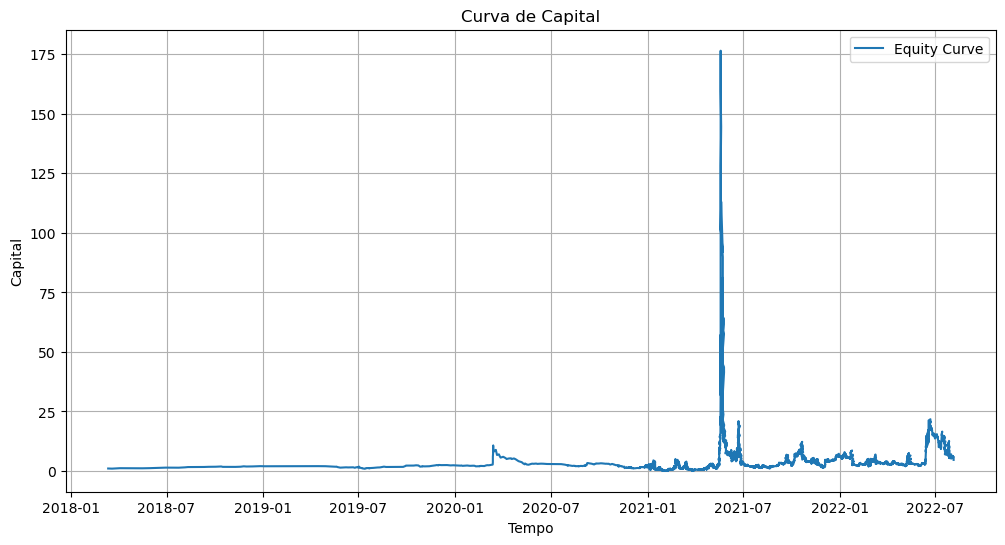


Estatísticas da Curva de Capital:
Capital Final: 4.650181139809825
Lucro Líquido: 3.650181139809825
Retorno Médio por Operação: 0.0033486454180521883
Drawdown Máximo Global: -0.9937352597988066

Exemplo de Drawdown Interno no Primeiro Trade:
entry_time               2018-03-07 21:48:39.376000
exit_time                2018-03-12 01:48:39.376000
max_drawdown_in_trade                     -0.120593
Name: 0, dtype: object


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def construct_trades_df(close, triple_barrier_events):
    # Filtra apenas eventos com retorno não nulo
    df = triple_barrier_events.dropna(subset=['retorno']).copy()

    # Determinar o horário de saída (exit_time) para cada operação
    # Procurar, entre pt, sl e t1, qual foi efetivamente preenchido
    def get_exit_time(row):
        times = []
        for col in ['pt', 'sl', 't1']:
            if pd.notna(row[col]):
                times.append((row[col], col))
        if not times:
            return np.nan
        # Ordenar por tempo e pegar o primeiro a ocorrer
        times.sort(key=lambda x: x[0])
        return times[0][0]

    df['exit_time'] = df.apply(get_exit_time, axis=1)

    # Calcular preços inicial e final
    # initial_price: preço no momento do evento
    # final_price: preço no momento da saída (usando asof)
    trades = []
    for loc, row in df.iterrows():
        entry_time = loc
        exit_time = row['exit_time']
        if pd.isna(exit_time):
            continue

        side = row.get('side', 1)  # se não existir, assume 1
        initial_price = close.asof(entry_time)
        final_price = close.asof(exit_time)
        trade_return = row['retorno']

        # Calcular drawdown dentro da operação
        # Obter trajetória de preços da operação
        trade_prices = close.loc[entry_time:exit_time]
        if side == 1:
            # Posição comprada
            rel = trade_prices / initial_price - 1
        else:
            # Posição vendida
            rel = initial_price / trade_prices - 1

        running_max = rel.cummax()
        dd = (rel / running_max) - 1
        max_dd = row['max_drawdown_in_trade']

        trades.append({
            'entry_time': entry_time,
            'exit_time': exit_time,
            'side': side,
            'initial_price': initial_price,
            'final_price': final_price,
            'return': trade_return,
            'max_drawdown_in_trade': max_dd
        })

    trades_df = pd.DataFrame(trades)
    return trades_df

def plot_equity_curve(trades_df, initial_capital=1.0):
    # Ordenar trades por entry_time
    trades_df = trades_df.sort_values('entry_time')
    # Curva de capital: multiplica cumulativamente por (1+retorno)
    equity_curve = initial_capital * (1 + trades_df['return']).cumprod()

    plt.figure(figsize=(12,6))
    plt.plot(trades_df['exit_time'], equity_curve, label='Equity Curve')
    plt.title('Curva de Capital')
    plt.xlabel('Tempo')
    plt.ylabel('Capital')
    plt.grid(True)
    plt.legend()
    plt.show()

    return equity_curve

# Exemplo de uso (assumindo que 'close' e 'triple_barrier_events' já existam):
trades_df = construct_trades_df(close, triple_barrier_events)
print("DataFrame Final com Entradas e Saídas:")
print(trades_df.head())

equity_curve = plot_equity_curve(trades_df)

# Estatísticas adicionais, se desejado
final_capital = equity_curve.iloc[-1] if not equity_curve.empty else np.nan
net_profit = (final_capital - 1) if pd.notna(final_capital) else np.nan
mean_return = trades_df['return'].mean() if not trades_df.empty else np.nan
max_dd_all = (equity_curve / equity_curve.cummax() - 1).min() if not equity_curve.empty else np.nan

print("\nEstatísticas da Curva de Capital:")
print(f"Capital Final: {final_capital}")
print(f"Lucro Líquido: {net_profit}")
print(f"Retorno Médio por Operação: {mean_return}")
print(f"Drawdown Máximo Global: {max_dd_all}")

# Mostrar drawdown interno de um trade específico:
# Por exemplo, do primeiro trade:
if not trades_df.empty:
    print("\nExemplo de Drawdown Interno no Primeiro Trade:")
    print(trades_df[['entry_time', 'exit_time', 'max_drawdown_in_trade']].iloc[0])
